### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import SimpleExpSmoothing


from scipy.optimize import minimize
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox

In [2]:
female_births = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/daily-total-female-births-in-cal.csv")['Count']
airline_passengers = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/international-airline-passengers.csv")['Count']
mean_monthly_temp = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/mean-monthly-air-temperature-deg.csv")["Deg"]
boston_rob = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/monthly-boston-armed-robberies-j.csv")['Count']
sales_of_company_x = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/monthly-sales-of-company-x-jan-6.csv")['Count']
dowjones_closings = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/weekly-closings-of-the-dowjones-.csv")["Close"]

### Определение основных функций

**Тест Дики-Фуллера на стационарность**

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

**Функция вывода коррелограмм**

In [4]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

**Функция метода скользящих средних**

Метод скользящих средних использует среднее значение последних i значений данных во временном ряду в качестве прогноза на следующий период. Каждый раз, когда для временного ряда становится доступным новое наблюдение, оно заменяет самое "старое" наблюдение и вычисляется новое среднее значение. В результате среднее значение будет изменяться или смещаться по мере поступления новых наблюдений.

Число i называют окном скользящего усреднения: чем оно больше, тем больше данных участвуют в расчете среднего, соответственно, тем более гладкая кривая получается. Очевидно, что при малых i сглаженные кривые практически повторяют ход изменения данных, а при больших i — отражают лишь закономерность.

In [5]:
def MovingAverage(series, window):
    global rolling_mean
    rolling_mean = series.rolling(window=window).mean()
    return rolling_mean

In [6]:
def pltMovingAverage(series, window, plot_intervals=False, scale=1.96):
    plt.figure(figsize=(15,10))
    plt.title("График приближения с использованием\n скользящего среднего")
        
    for n in np.linspace(5, 20, 4, dtype=int):
        plt.plot(MovingAverage(series, n), label="Размер окна: {}".format(n))
        plt.legend(loc="best")
        plt.grid(True);
    
    if plot_intervals:
        mae = mean_absolute_error(series[n:], rolling_mean[n:])
        deviation = np.std(series[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--", label="Верхний ус / Нижний ус")
        plt.plot(lower_bond, "g--")

    plt.plot(series[n:], color="c", label="Текущие значения")
    plt.legend(loc="upper left")
    plt.grid(True)

### Взвешеннoе скользящее среднее

В методе скользящих средних каждое наблюдение при расчете получает одинаковый вес. Взвешенное скользящее среднее предполагает, что у каждого наблюдения будет свой вес. В большинстве случаев наибольшее значение имеет самое последнее наблюдение, а для более старых значений вес уменьшается.

In [7]:
def weighted_average(series, window, weights):
    weights = np.array(weights)
    series = pd.Series(series)
    wma = series.rolling(window).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [27]:
def pltWeightedAverage(series, window, weights):
    plt.figure(figsize=(15,10))
    plt.title("График приближения с использованием\n взвешенного среднего")

    for weight in weights:
        wma = weighted_average(series, window, weight)  
        _ = plt.plot(wma, linewidth='1', label=f"WMA {weight}")
        plt.legend(loc="best")
        plt.grid(True);

    plt.plot(series.values, color="c", label="Текущие значения")
    plt.legend(loc="upper left")
    plt.grid(True)

### Экспоненциальное сглаживание

Экспоненциальное сглаживание также использует средневзвешенное значение прошлых значений временных рядов в качестве прогноза. Только в этом случае мы начинаем взвешивать все доступные наблюдения, экспоненциально уменьшая веса по мере продвижения все дальше назад во времени.

То есть в данной модели мы берем все предыдущие значения, задаем каждому из наблюдений определенный вес и экспоненциально уменьшаем этот вес по мере углубления в прошлое. "Важность" этих значений определяется параметром $\alpha$, который варьируется от 0 до 1. 

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [10]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 10))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "olive", alpha = 0.6, label = "Текущее значение")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Экспоненциальное сглаживание")
        plt.grid(True);

## Cтационарный ряд

**daily-total-female-births-in-cal**

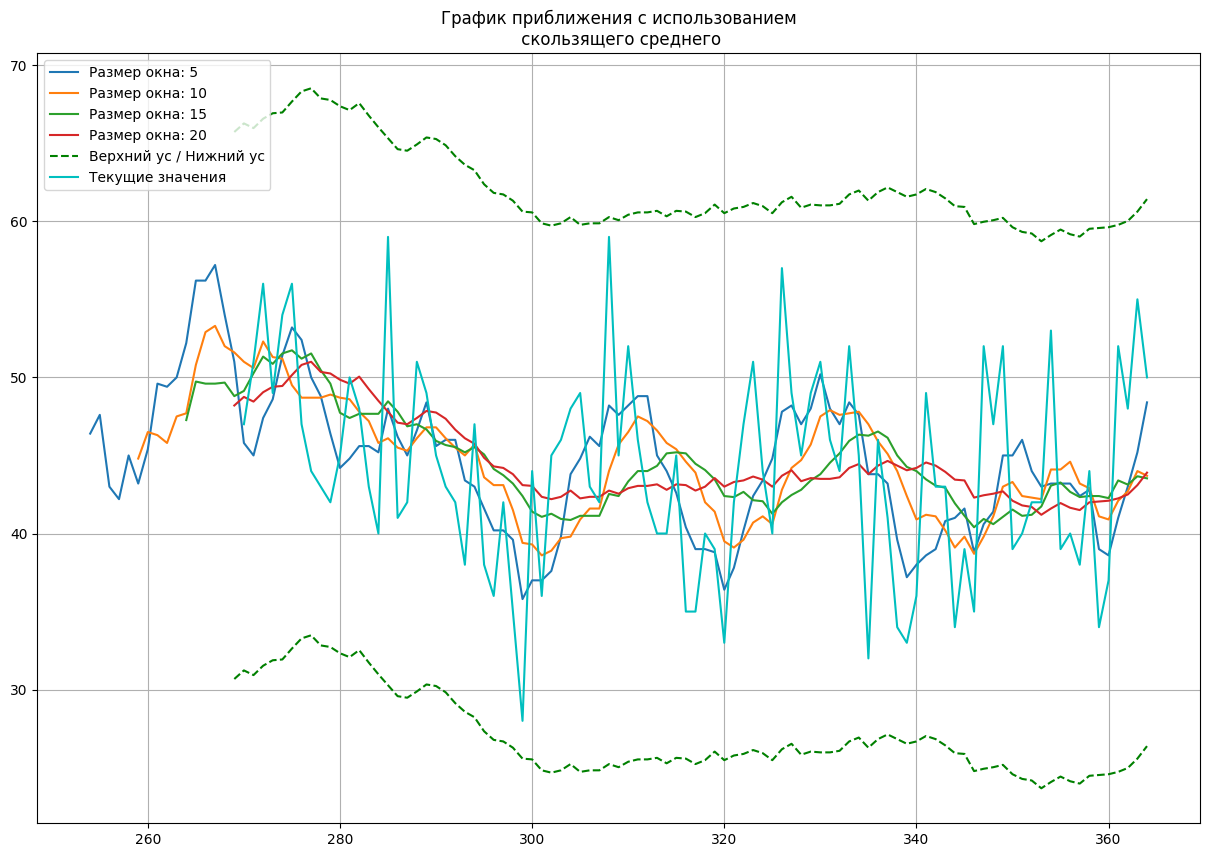

In [11]:
pltMovingAverage(female_births[250:], 12, plot_intervals=True)

График скользящего среднего хорошо демонстрирует тренд. Чем больше размер "окна" скользящего среднего, тем более сглаженным получается результат. И наооборот.

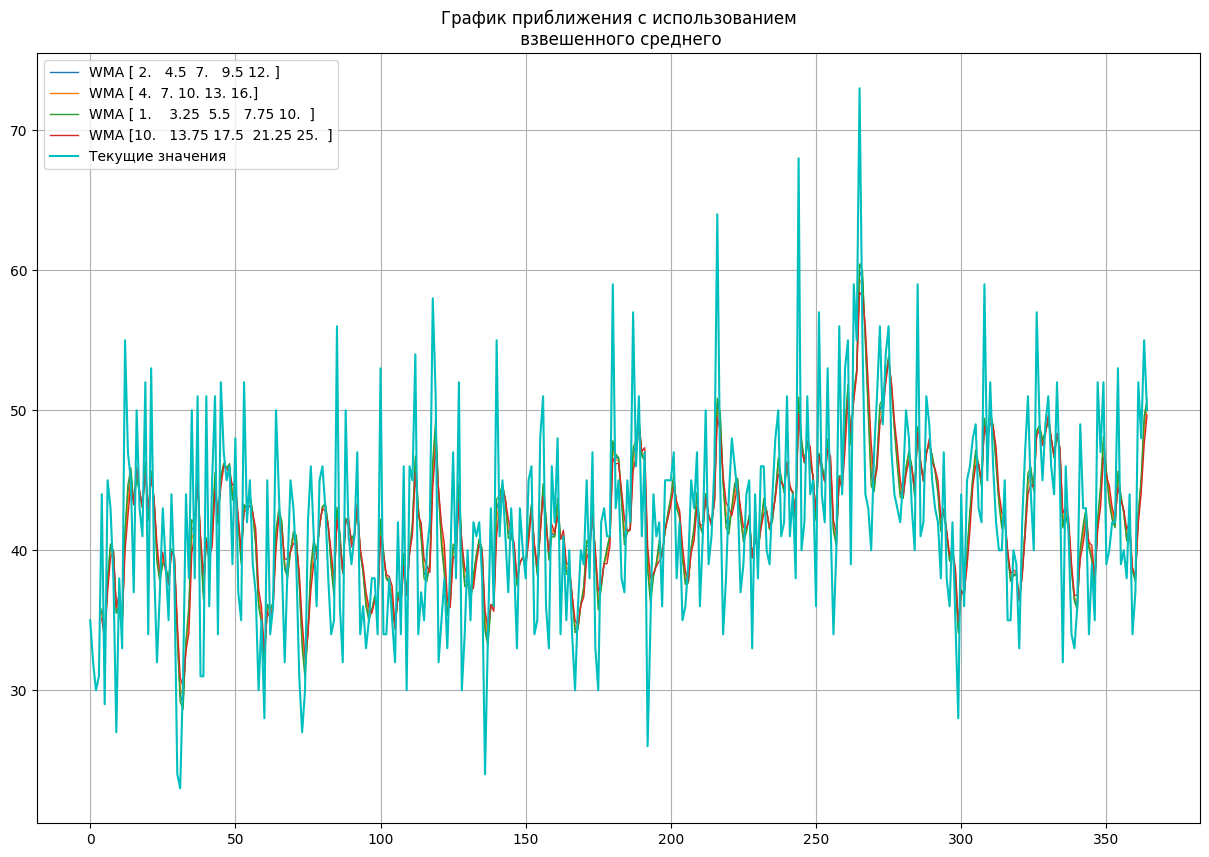

In [12]:
pltWeightedAverage(female_births, 5, [np.linspace(2,12,5), np.linspace(4,16,5), np.linspace(1,10,5), np.linspace(10,25,5)])

График взвешенного среднего безусловно лучше приближает наши данные по рождаемости, так как поздним данным был присвоен максимальный вес.

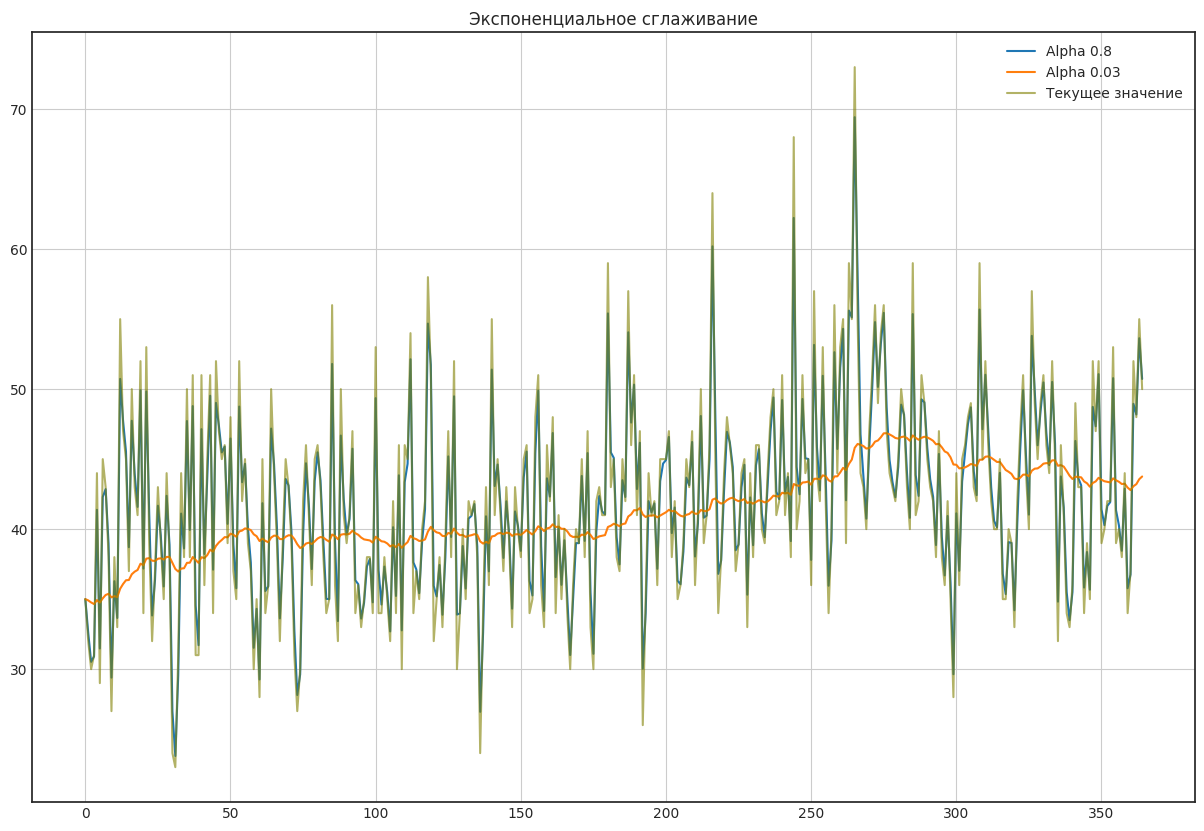

In [13]:
plotExponentialSmoothing(female_births, [0.8, 0.03])

Как мы видим на графике, чем меньше значение α, тем большее влияние на движение графика оказывают предыдующие значения. При высоких значениях α сглаживание становится минимальным.

## Оценка модели



In [14]:
len(female_births)

365

In [15]:
test = female_births.iloc[:290]
train = female_births.iloc[290:]

In [16]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    print('Результаты оценки:')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [17]:
temp_df = []
df3 = {}
for i in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(f'Alpha = {i}')
    fit_model = SimpleExpSmoothing(np.asarray(train)).fit(i)
    pred_v= fit_model.forecast(290)
    timeseries_evaluation_metrics_func(test, pred_v)
    rmse = np.sqrt(metrics.mean_squared_error(test, pred_v))
    df3 = {'Alpha':i, 'RMSE': rmse}
    temp_df.append(df3)

Alpha = 0.05
Результаты оценки:
MSE is : 60.98970954981208
MAE is : 6.168374145564388
RMSE is : 7.809590869553416
R2 is : -0.0699627633146167

Alpha = 0.1
Результаты оценки:
MSE is : 65.6101437336221
MAE is : 6.445504377343804
RMSE is : 8.100008872440949
R2 is : -0.15102057722312567

Alpha = 0.2
Результаты оценки:
MSE is : 81.02881427181293
MAE is : 7.390522977380528
RMSE is : 9.001600650540599
R2 is : -0.421515443610486

Alpha = 0.3
Результаты оценки:
MSE is : 100.2457727904676
MAE is : 8.437158974194386
RMSE is : 10.012281098254663
R2 is : -0.7586449395679802

Alpha = 0.4
Результаты оценки:
MSE is : 118.32316219094636
MAE is : 9.29258595593621
RMSE is : 10.877645066417012
R2 is : -1.0757825953991387

Alpha = 0.5
Результаты оценки:
MSE is : 131.6311394417366
MAE is : 9.866372720344964
RMSE is : 11.473061467704973
R2 is : -1.3092488673077485

Alpha = 0.6
Результаты оценки:
MSE is : 138.92253090338264
MAE is : 10.170532772898344
RMSE is : 11.7865402431495
R2 is : -1.4371641732552165

Al

In [18]:
final_df = pd.DataFrame(temp_df)
final_df.sort_values('RMSE')

,Alpha,RMSE
0,0.05,7.809591
1,0.10,8.100009
2,0.20,9.001601
3,0.30,10.012281
4,0.40,10.877645
10,1.00,11.217597
5,0.50,11.473061
9,0.90,11.541131
8,0.80,11.765933
6,0.60,11.786540


Создадим графики с разными уровнями сглаживания

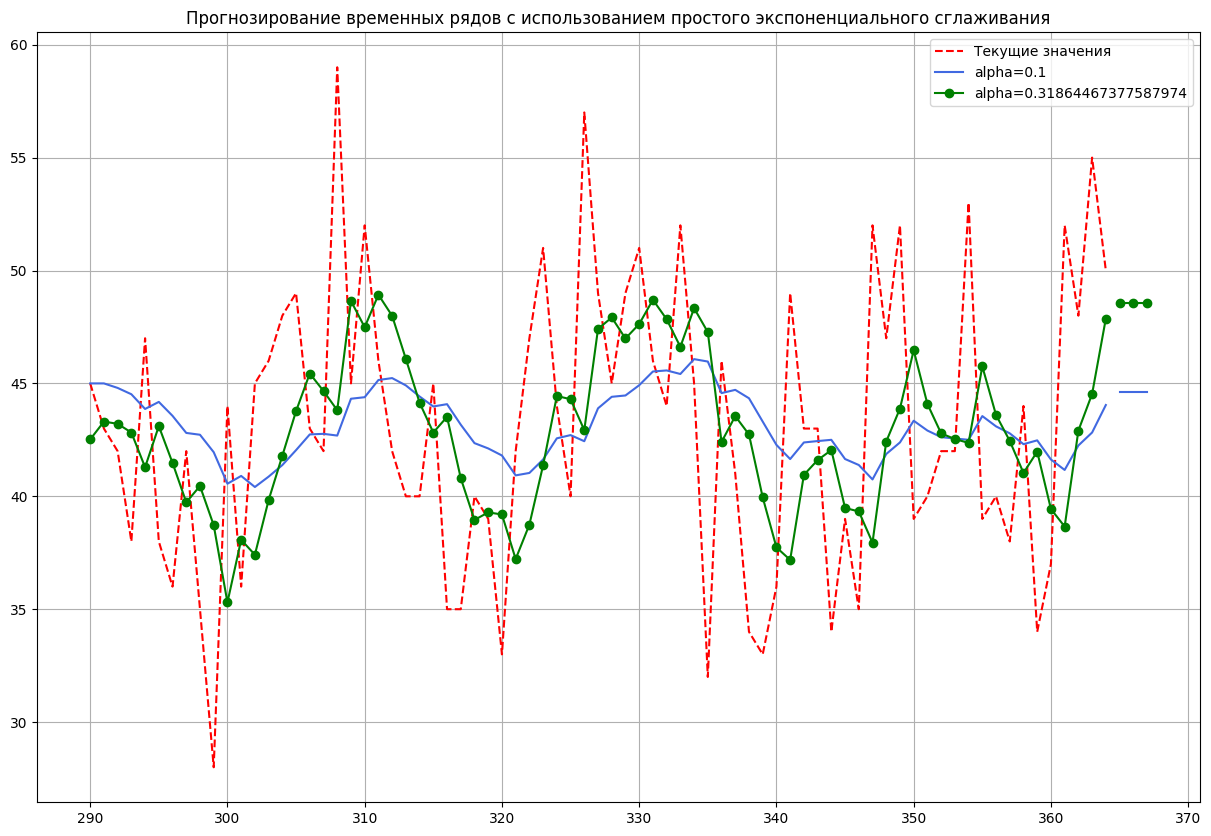

In [19]:
SES01 = SimpleExpSmoothing(female_births[290:]).fit(smoothing_level=0.1, optimized=False)
SES01_cast = SES01.forecast(3).rename('alpha=0.1')

SES_auto = SimpleExpSmoothing(female_births[290:]).fit()
SES_auto_cast = SES_auto.forecast(3).rename('alpha=%s'%SES_auto.model.params['smoothing_level'])

ax = female_births[290:].plot(color = 'red', linestyle = 'dashed', label="Текущие значения", figsize=(15,10))

SES01_cast.plot(ax=ax, color='royalblue')
SES01.fittedvalues.plot(ax=ax, color='royalblue')

SES_auto_cast.plot(marker='o', ax=ax, color='green')
SES_auto.fittedvalues.plot(marker='o', ax=ax, color='green')

plt.legend(loc="best")
plt.axis('tight')
plt.title("Прогнозирование временных рядов с использованием простого экспоненциального сглаживания")
plt.grid(True)
plt.show()

Красная пунктирная линия на графике - это наши фактические значения. Зеленая - линия построена по значениям автоматически оптимизированным SES. Синяя линия - это $\alpha$ с параметром 0.1

Здесь мы также можем увидеть, что SES предсказывает показатели рождаемости на следующий временной отрезок. Он находится в районе 48, что, в принципе представляется возможным.

## Нестационарный ряд

**international-airline-passengers**

In [20]:
len(airline_passengers)

144

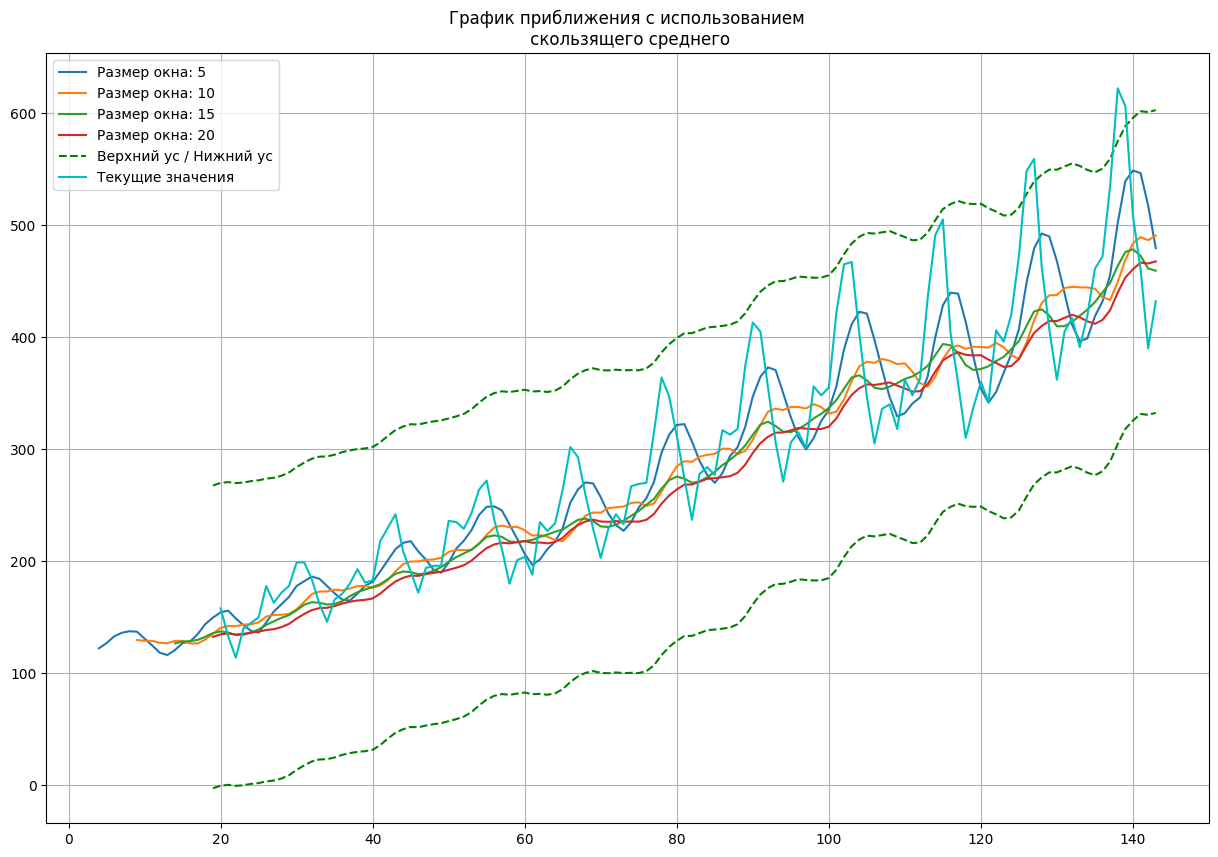

In [21]:
pltMovingAverage(airline_passengers, 12, plot_intervals=True) 

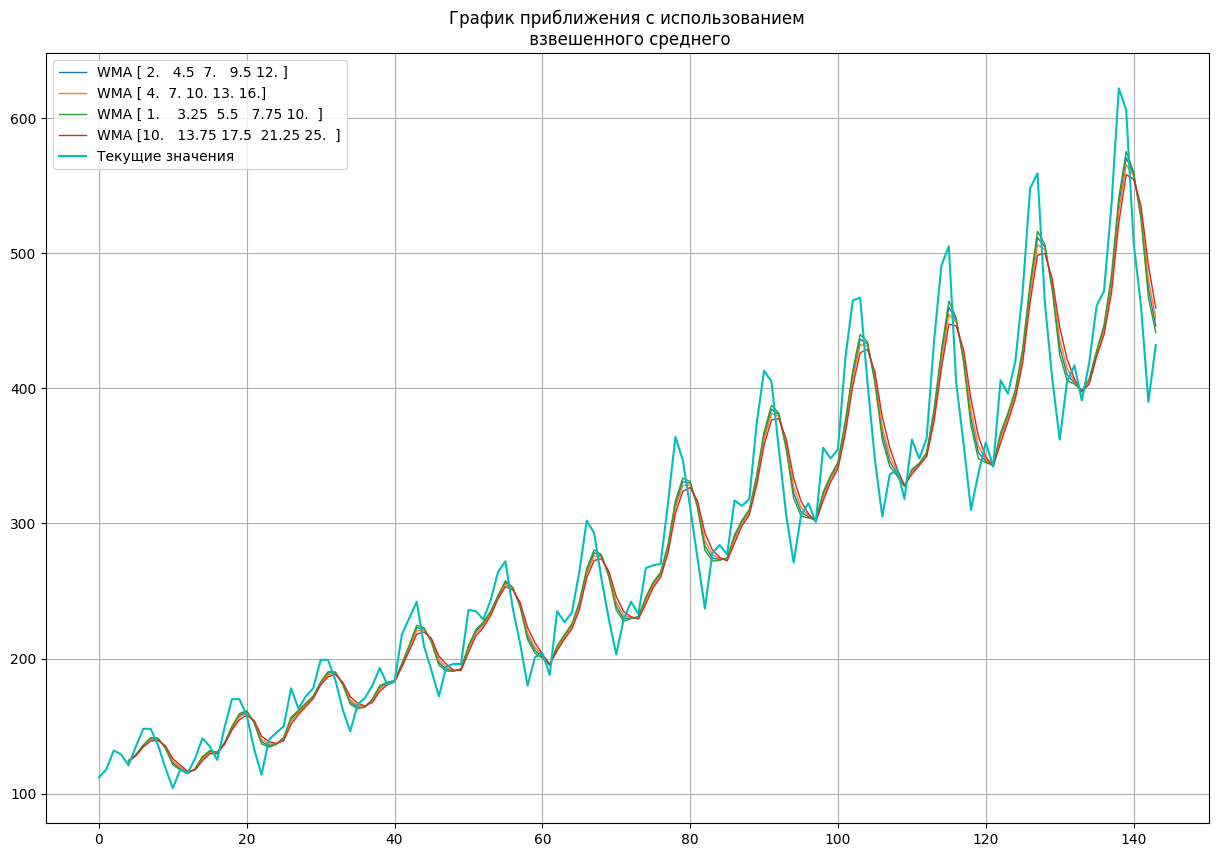

In [28]:
pltWeightedAverage(airline_passengers, 5, [np.linspace(2,12,5), np.linspace(4,16,5), np.linspace(1,10,5), np.linspace(10,25,5)])

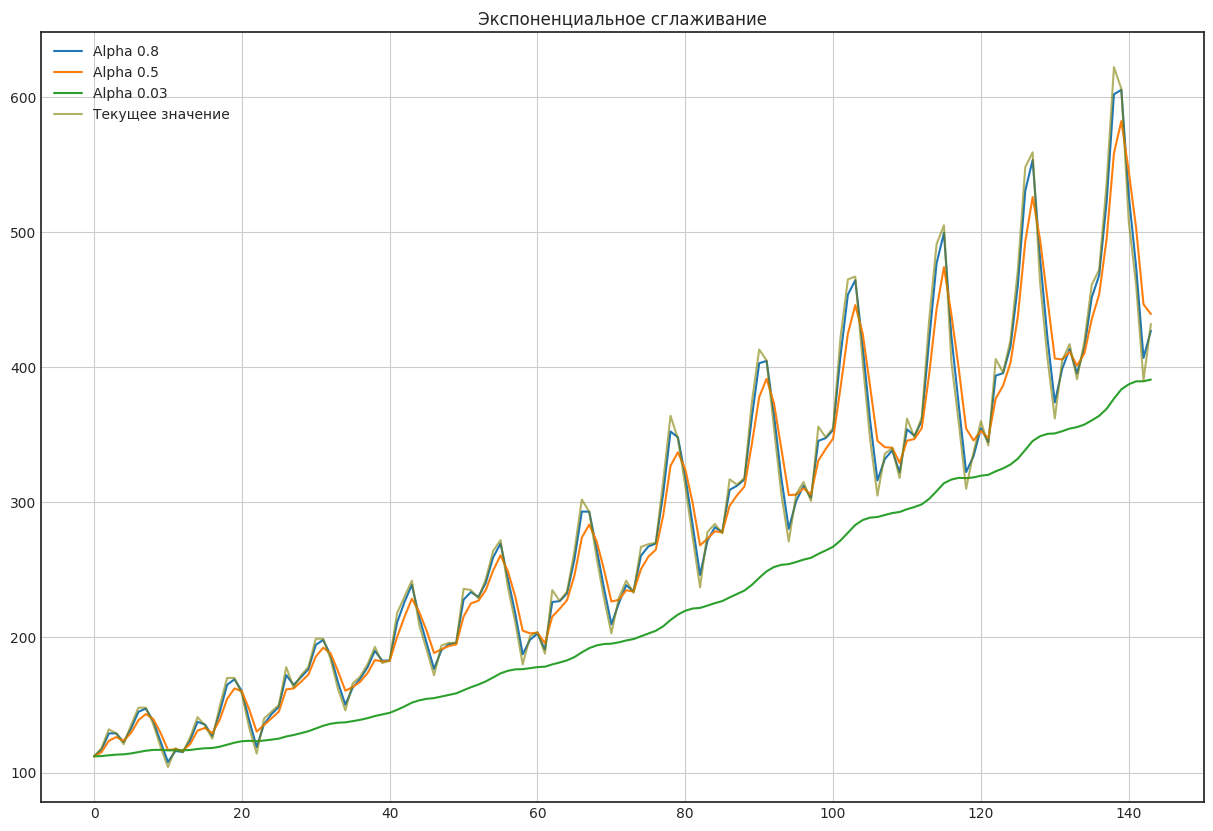

In [40]:
plotExponentialSmoothing(airline_passengers, [0.8, 0.5, 0.03])

### Оценка модели

In [30]:
test = airline_passengers.iloc[:115]
train = airline_passengers.iloc[115:]

In [33]:
temp_df_air = []
df_air = {}
for i in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(f'Alpha = {i}')
    fit_model = SimpleExpSmoothing(np.asarray(train)).fit(i)
    pred_v = fit_model.forecast(115)
    timeseries_evaluation_metrics_func(test, pred_v)
    rmse = np.sqrt(metrics.mean_squared_error(test, pred_v))
    df_air = {'Alpha':i, 'RMSE': rmse}
    temp_df_air.append(df_air)

Alpha = 0.05
Результаты оценки:
MSE is : 51996.86849310069
MAE is : 210.42423074961783
RMSE is : 228.028218633354
R2 is : -5.285996153009762

Alpha = 0.1
Результаты оценки:
MSE is : 57732.46966199308
MAE is : 223.0228834864296
RMSE is : 240.27581996945318
R2 is : -5.97938342666144

Alpha = 0.2
Результаты оценки:
MSE is : 61033.44492514515
MAE is : 230.07026581241112
RMSE is : 247.04947869838776
R2 is : -6.378444339495211

Alpha = 0.3
Результаты оценки:
MSE is : 57475.418802844564
MAE is : 222.47441289016805
RMSE is : 239.7403153473453
R2 is : -5.948308080038405

Alpha = 0.4
Результаты оценки:
MSE is : 52370.06446959264
MAE is : 211.26823944899783
RMSE is : 228.84506651792307
R2 is : -5.331112494445947

Alpha = 0.5
Результаты оценки:
MSE is : 47995.61656097164
MAE is : 201.13831996501085
RMSE is : 219.07901898851847
R2 is : -4.802277517993821

Alpha = 0.6
Результаты оценки:
MSE is : 45064.04737003418
MAE is : 194.09041620144995
RMSE is : 212.28294177826484
R2 is : -4.447874778164211

Al

In [34]:
final_df_air = pd.DataFrame(temp_df_air)
final_df_air.sort_values('RMSE')

,Alpha,RMSE
8,0.80,207.965647
7,0.70,208.722560
9,0.90,209.401530
6,0.60,212.282942
10,1.00,212.499166
5,0.50,219.079019
0,0.05,228.028219
4,0.40,228.845067
3,0.30,239.740315
1,0.10,240.275820


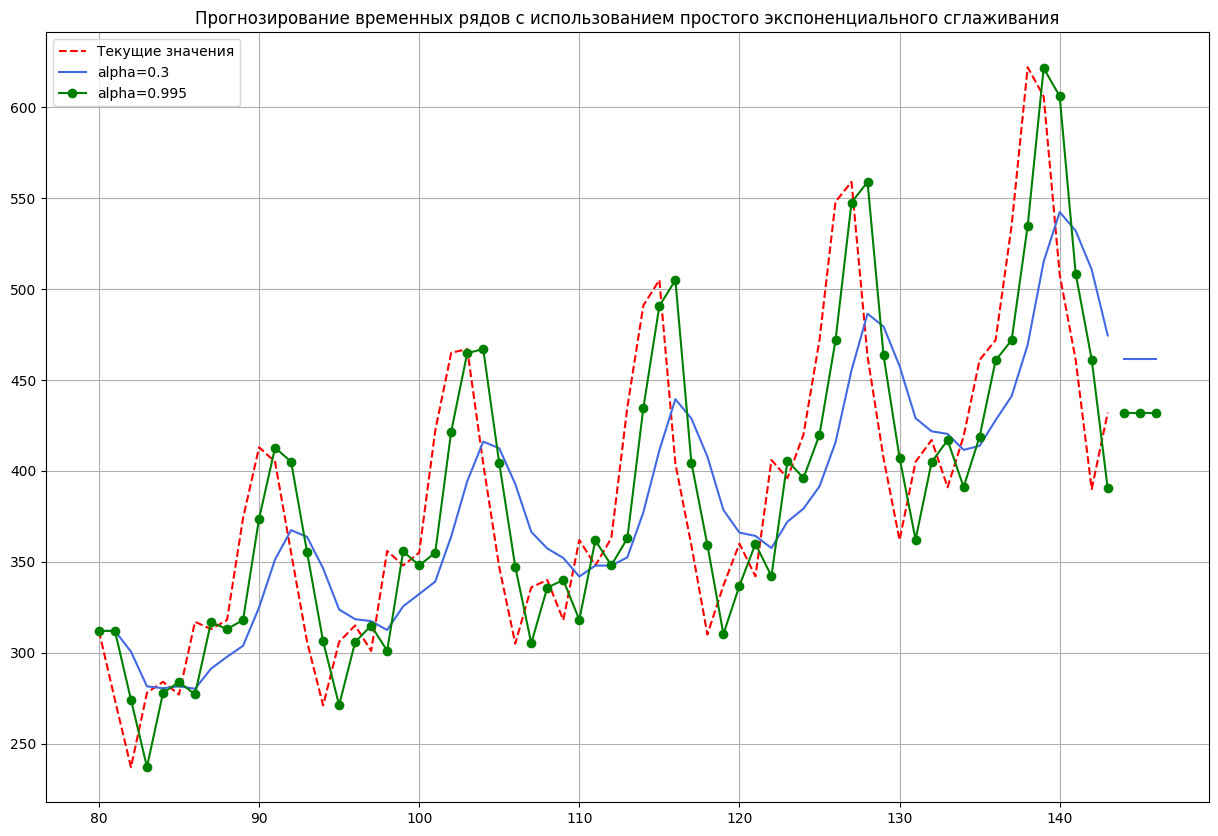

In [41]:
SES03 = SimpleExpSmoothing(airline_passengers[80:]).fit(smoothing_level=0.3, optimized=False)
SES03_cast = SES03.forecast(3).rename('alpha=0.3')

SES_auto = SimpleExpSmoothing(airline_passengers[80:]).fit()
SES_auto_cast = SES_auto.forecast(3).rename('alpha=%s'%SES_auto.model.params['smoothing_level'])

ax = airline_passengers[80:].plot(color = 'red', linestyle = 'dashed', label="Текущие значения", figsize=(15,10))

SES03_cast.plot(ax=ax, color='royalblue')
SES03.fittedvalues.plot(ax=ax, color='royalblue')

SES_auto_cast.plot(marker='o', ax=ax, color='green')
SES_auto.fittedvalues.plot(marker='o', ax=ax, color='green')

plt.legend(loc="best")
plt.axis('tight')
plt.title("Прогнозирование временных рядов с использованием простого экспоненциального сглаживания")
plt.grid(True)
plt.show()

Интересно отметить, что, как мы помним, чем меньше α, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. На прошлом примере, где наши ряды были стационарными, наилучших значений мы добились при низких показателях α. А в данном примере (нестационарные данные), напротив, оптимальные значения достигаются при высоких α.